In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Configurações de plotagem
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 5)

## [1] Leitura do Arquivo LHE

**Fazendo a leitura utilizando um dataframe do pandas.**

In [12]:
def lhe_to_dataframe(filename, label):
    """
    Lê um arquivo .lhe e converte para um DataFrame Pandas.
    Extrai apenas as informações das partículas dentro dos blocos <event>.
    """
    try:
        # LHE é um formato misto (XML + Texto tabular). 
        # O jeito mais seguro via Pandas é parsear o XML e processar o texto.
        tree = ET.parse(filename)
        root = tree.getroot()
    except Exception as e:
        print(f"Erro ao ler o arquivo {filename}: {e}")
        return pd.DataFrame()

    all_particles = []
    
    # Itera sobre cada evento no arquivo
    for event_id, event in enumerate(root.findall('event')):
        lines = event.text.strip().split('\n')
        
        # A primeira linha é o cabeçalho do evento (ignoramos aqui, pegamos só partículas)
        # As linhas subsequentes são as partículas
        for line in lines[1:]:
            parts = line.split()
            if len(parts) < 13: continue # Garante que a linha está completa
            
            # Estrutura padrão LHE:
            # ID Status Mother1 Mother2 Color1 Color2 Px Py Pz E Mass VTIM SPIN
            particle_data = {
                'event_id': event_id,
                'pdg_id': int(parts[0]),
                'status': int(parts[1]),
                'mother1': int(parts[2]),
                'mother2': int(parts[3]),
                'px': float(parts[6]),
                'py': float(parts[7]),
                'pz': float(parts[8]),
                'e': float(parts[9]),
                'mass': float(parts[10]),
                'label': label  # Identifica se é Sinal ou Fundo
            }
            all_particles.append(particle_data)

    # Cria o DataFrame
    df = pd.DataFrame(all_particles)
    return df

# --- DEFINA OS CAMINHOS DOS SEUS ARQUIVOS AQUI ---
# Exemplo: 'caminho/para/sinal.lhe' e 'caminho/para/fundo.lhe'
file_signal = './data/signal.lhe' 
file_background = './data/background.lhe'

print("Lendo arquivos... (isso pode demorar dependendo do tamanho)")

# Leitura (Se não tiver o arquivo de fundo, comente a linha correspondente)
df_signal = lhe_to_dataframe(file_signal, 'Sinal')
df_bkg = lhe_to_dataframe(file_background, 'Fundo')

# Concatena os dois para facilitar análises conjuntas, mas mantém o label
if not df_bkg.empty:
    df_total = pd.concat([df_signal, df_bkg], ignore_index=True)
else:
    df_total = df_signal.copy()

print("Leitura concluída!")
df_total.head()

Lendo arquivos... (isso pode demorar dependendo do tamanho)
Leitura concluída!


,event_id,pdg_id,status,mother1,mother2,px,py,pz,e,mass,label
0,0,21,-1,0,0,0.000000,0.000000,103.849954,103.849954,0.000000,Sinal
1,0,21,-1,0,0,-0.000000,-0.000000,-37.615172,37.615172,0.000000,Sinal
2,0,25,2,1,2,0.000000,0.000000,66.234782,141.465126,125.001342,Sinal
3,0,22,1,3,3,53.205388,-32.691024,36.072332,72.116083,0.000000,Sinal
4,0,22,1,3,3,-53.205388,32.691024,30.162450,69.349043,0.000000,Sinal


## [2a] Investigação Preliminar do Arquivo

### Objetivo:
**Exibir o número total de eventos da amostra com o método escolhido.**

In [13]:
# Conta eventos únicos baseados no 'event_id' para cada label
n_events_signal = df_total[df_total['label'] == 'Sinal']['event_id'].nunique()
n_events_bkg = df_total[df_total['label'] == 'Fundo']['event_id'].nunique()

print(f"=== Contagem de Eventos ===")
print(f"Número total de eventos (Sinal): {n_events_signal}")
if n_events_bkg > 0:
    print(f"Número total de eventos (Fundo): {n_events_bkg}")
print(f"Total combinado: {n_events_signal + n_events_bkg}")

=== Contagem de Eventos ===
Número total de eventos (Sinal): 10000
Número total de eventos (Fundo): 10000
Total combinado: 20000


## [2b] Investigação Preliminar dos Eventos

### Objetivo 1:
**Construir uma tabela das partículas presentes nos eventos, classificadas pelos seus status:**

In [14]:
def analyze_particles(df, label_name):
    print(f"\n--- Análise de Partículas: {label_name} ---")
    subset = df[df['label'] == label_name]
    
    # Status padrão LHE: -1 (Entrada), 1 (Saída estável), 2 (Intermediário/Ressonância)
    status_map = {-1: 'Inicial', 1: 'Final (Detectável)', 2: 'Intermediária'}
    
    # Agrupa por Status e PDG ID
    summary = subset.groupby(['status', 'pdg_id']).size().reset_index(name='contagem')
    summary['desc_status'] = summary['status'].map(status_map)
    
    # Exibe tabela formatada
    print(summary[['status', 'desc_status', 'pdg_id', 'contagem']].to_string(index=False))

# Executa para o Sinal
analyze_particles(df_total, 'Sinal')

# Executa para o Fundo (se existir)
if n_events_bkg > 0:
    analyze_particles(df_total, 'Fundo')


--- Análise de Partículas: Sinal ---
 status        desc_status  pdg_id  contagem
     -1            Inicial      21     20000
      1 Final (Detectável)      22     20000
      2      Intermediária      25      9796

--- Análise de Partículas: Fundo ---
 status        desc_status  pdg_id  contagem
     -1            Inicial      -4      1682
     -1            Inicial      -3       154
     -1            Inicial      -2      7694
     -1            Inicial      -1       470
     -1            Inicial       1       470
     -1            Inicial       2      7694
     -1            Inicial       3       154
     -1            Inicial       4      1682
      1 Final (Detectável)      22     20000


## [2b] Investigação Preliminar dos Eventos

### Objetivo 2:
**Com base nas partículas e seus status, identificar:**

**- Qual é o processo de sinal?**

$gg \to H \to \gamma\gamma$

**- Qual é o processo de fundo (background)?**

$ q\bar{q} \to \gamma\gamma $

Podendo ser:

$ u\bar{u} \to \gamma\gamma $ (76.94%)

$ c\bar{c} \to \gamma\gamma $ (16.82%)

$ d\bar{d} \to \gamma\gamma $ (4.70%)

$ s\bar{s} \to \gamma\gamma $ (1.54%)

## [3] Exploração do Conteúdo

### Objetivo 1:
**Construir histogramas para as partículas de estado final (exceto neutrinos), com as variáveis cinemáticas:**

### Objetivo 2:
**Imprimir o número total de eventos representados em cada histograma.**

### Pergunta:
**Os histogramas representam todos os eventos do arquivo LHE?** 
**Se não, explique o porquê (por exemplo: presença ou ausência de certas partículas nos eventos).**

Sim, pois não foi feito nenhum corte e não havia nenhum evento contendo apenas neutrinos.

Cálculos cinemáticos realizados e neutrinos removidos dos dados de plotagem.


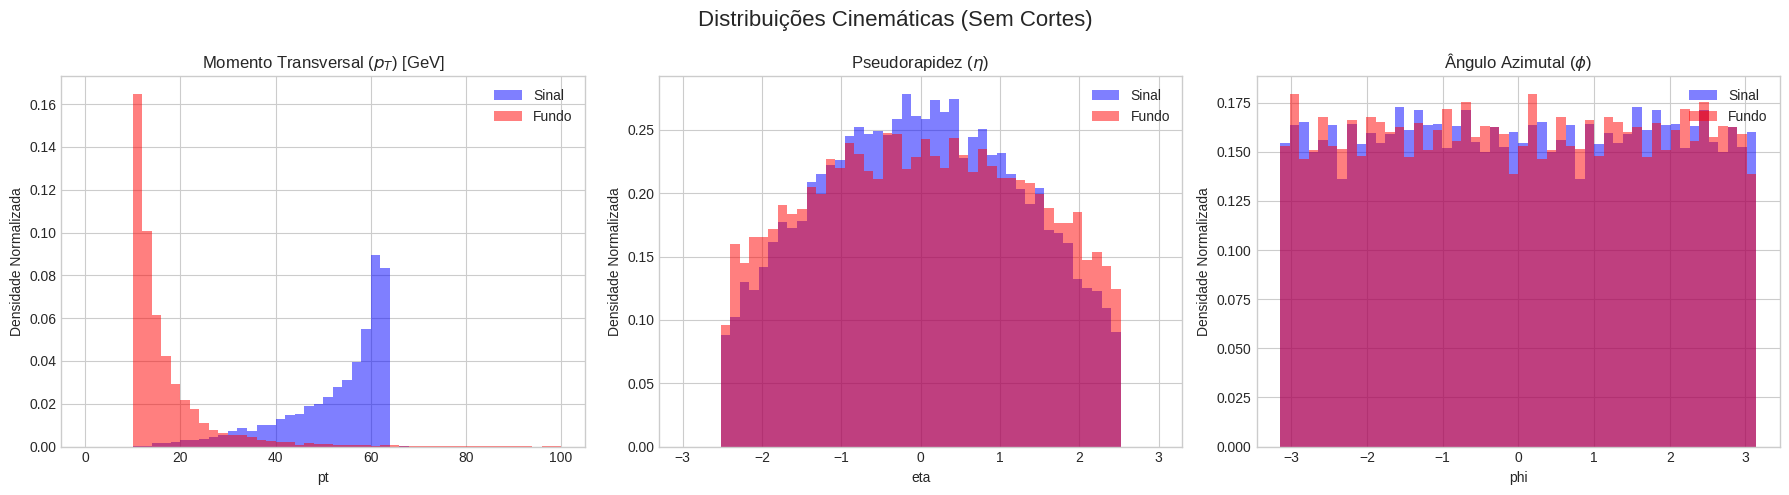

--- Estatísticas do Gráfico (Sem Cortes) ---
[Sinal] Entradas (partículas) plotadas: 20000 | Eventos originais: 10000
[Fundo] Entradas (partículas) plotadas: 20000 | Eventos originais: 10000


In [15]:
# Funções para cálculo cinemático
def calculate_kinematics(df):
    # pT = sqrt(px^2 + py^2)
    df['pt'] = np.sqrt(df['px']**2 + df['py']**2)
    
    # phi = arctan2(py, px)
    df['phi'] = np.arctan2(df['py'], df['px'])
    
    # theta e pseudorapidez (eta)
    # p_total = sqrt(pt^2 + pz^2)
    p_total = np.sqrt(df['pt']**2 + df['pz']**2)
    
    # Evitar divisão por zero e logs inválidos
    # eta = 0.5 * ln((p + pz) / (p - pz))
    with np.errstate(divide='ignore', invalid='ignore'):
        df['eta'] = 0.5 * np.log((p_total + df['pz']) / (p_total - df['pz']))
        
    return df

# Aplica os cálculos
df_total = calculate_kinematics(df_total)

# Filtragem para Plotagem (Objetivo 1):
# 1. Apenas estado final (Status = 1)
# 2. Excluir Neutrinos (PDG IDs: 12, 14, 16 e antipartículas -12, -14, -16)
neutrinos = [12, 14, 16, -12, -14, -16]

df_plot = df_total[
    (df_total['status'] == 1) & 
    (~df_total['pdg_id'].isin(neutrinos))
].copy()

print("Cálculos cinemáticos realizados e neutrinos removidos dos dados de plotagem.")

def plot_histograms(df, title_suffix=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    variables = [
        ('pt', 'Momento Transversal ($p_T$) [GeV]', 50, (0, 100)),
        ('eta', 'Pseudorapidez ($\eta$)', 50, (-3, 3)),
        ('phi', 'Ângulo Azimutal ($\phi$)', 50, (-np.pi, np.pi))
    ]
    
    labels = df['label'].unique()
    colors = {'Sinal': 'blue', 'Fundo': 'red'}
    
    for i, (var, title, bins, rnge) in enumerate(variables):
        ax = axes[i]
        
        # Loop para plotar Sinal e Fundo sobrepostos
        for lab in labels:
            data = df[df['label'] == lab][var]
            # remove NaNs gerados por eta infinito se houver
            data = data.dropna()
            
            ax.hist(data, bins=bins, range=rnge, alpha=0.5, label=lab, 
                    color=colors.get(lab, 'gray'), density=True) # density=True para comparar formas
            
        ax.set_title(title)
        ax.set_xlabel(var)
        ax.set_ylabel("Densidade Normalizada")
        ax.legend()
        
    plt.suptitle(f"Distribuições Cinemáticas {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Objetivo 2: Imprimir número de eventos representados
    print(f"--- Estatísticas do Gráfico {title_suffix} ---")
    for lab in labels:
        n_entries = len(df[df['label'] == lab])
        n_ev = df[df['label'] == lab]['event_id'].nunique()
        print(f"[{lab}] Entradas (partículas) plotadas: {n_entries} | Eventos originais: {n_ev}")

# Plotagem Inicial
plot_histograms(df_plot, "(Sem Cortes)")

## [4] Filtros e Cortes Cinemáticos

### Objetivo 1:
**Analisar se cortes cinemáticos simples ajudam a remover o fundo.**

Sim, ajudam.

### Objetivo 2:
**Se for útil, aplique o corte e reconstrua os histogramas com a nova seleção.**

Aplicarei os cortes $p_T>\text{ 20.0 GeV}$ e $|\eta| < 2.5$ (valor típico do CMS).

Aplicando cortes: pT > 20.0 GeV e |eta| < 2.5


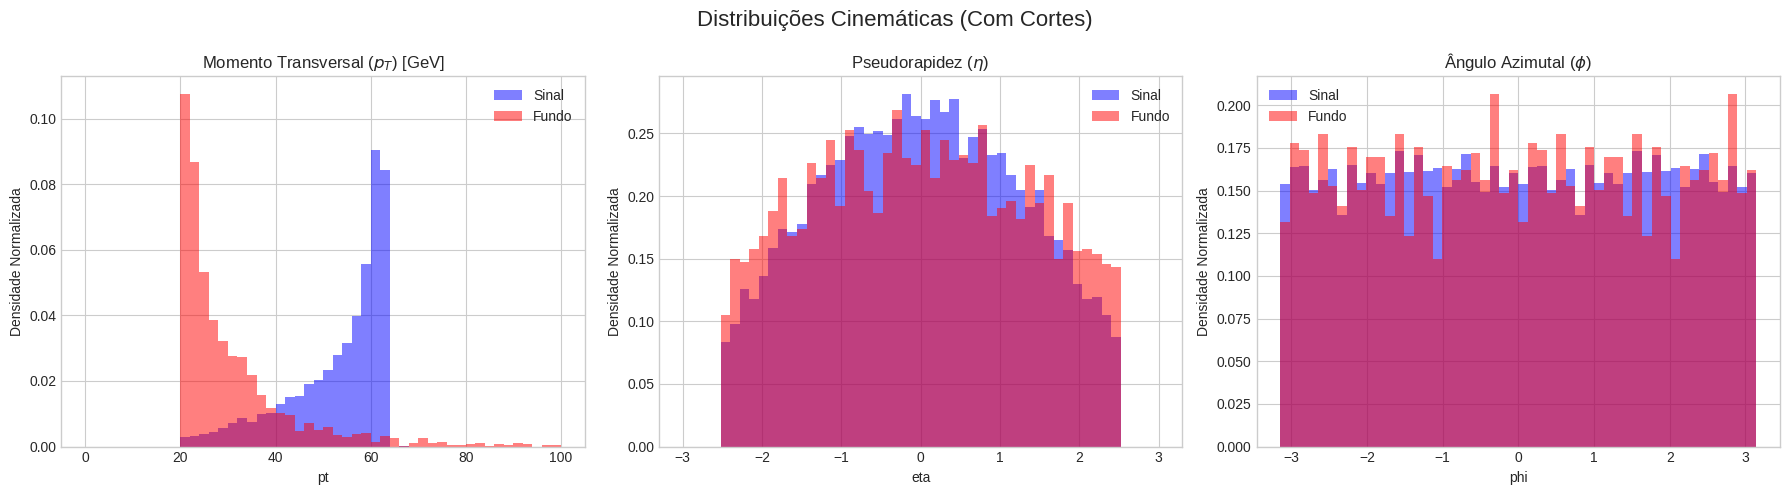

--- Estatísticas do Gráfico (Com Cortes) ---
[Sinal] Entradas (partículas) plotadas: 19776 | Eventos originais: 9888
[Fundo] Entradas (partículas) plotadas: 4120 | Eventos originais: 2060

--- Eficiência do Corte (Partículas Sobreviventes) ---
[Sinal] 20000 -> 19776 (98.88%)
[Fundo] 20000 -> 4120 (20.60%)


In [16]:
# --- Configuração dos Cortes ---
# Exemplo: Selecionar apenas partículas com alto pT e centrais (eta baixo)
CUT_PT = 20.0  # GeV
CUT_ETA = 2.5  # Valor absoluto

print(f"Aplicando cortes: pT > {CUT_PT} GeV e |eta| < {CUT_ETA}")

# Aplica o filtro no DataFrame já preparado para plot (df_plot)
df_cut = df_plot[
    (df_plot['pt'] > CUT_PT) & 
    (df_plot['eta'].abs() < CUT_ETA)
].copy()

# Reconstrói os histogramas
plot_histograms(df_cut, "(Com Cortes)")

# Análise de eficiência
print("\n--- Eficiência do Corte (Partículas Sobreviventes) ---")
for lab in df_plot['label'].unique():
    original = len(df_plot[df_plot['label'] == lab])
    final = len(df_cut[df_cut['label'] == lab])
    if original > 0:
        eff = (final / original) * 100
        print(f"[{lab}] {original} -> {final} ({eff:.2f}%)")